In [32]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, classification_report, confusion_matrix

def evaluate_new_ad_data(model, fitted_vectorizer, num_pairs=20000):
    """
    Evaluate a trained model on new ad copy data using pairwise comparisons.

    Parameters:
    - filepath (str): Path to the CSV file with new ad data.
    - model (fitted classifier): Trained model with predict and predict_proba methods.
    - vectorizer (fitted vectorizer): Pre-fitted BoW/TF-IDF vectorizer.
    - num_pairs (int): Number of random pairs to generate for evaluation.

    Returns:
    - None (prints evaluation metrics)
    """

    # Load data
    filepath="Ad report.csv"
    df_new = pd.read_csv(filepath)

    # Combine text fields into one 'Text' column
    df_new['Text'] = df_new[['Headline 1', 'Headline 2', 'Headline 3',
                             'Description 1', 'Description 2', 'Description 3']].fillna("").agg(" ".join, axis=1).str.lower()

    # Ensure CTR column exists and compute log CTR
    assert 'CTR' in df_new.columns, "CTR column is required in the new test data."
    epsilon = 1e-5  # to avoid log(0)
    ctrs_new =df_new['CTR'].values

    # Vectorize text using pre-fitted vectorizer
    bow_new = fitted_vectorizer.transform(df_new['Text']).toarray()
    #embeddings_new = fitted_vectorizer.encode(df_new['Text'].tolist())
    # Generate pairwise inputs
    def generate_eval_pairs(bow, ctrs, num_pairs):
        X, y_true = [], []
        n = len(bow)
        for _ in tqdm(range(num_pairs), desc="Generating pairs"):
            i, j = np.random.choice(n, 2, replace=False)
            xi, xj = bow[i], bow[j]
            yi, yj = ctrs[i], ctrs[j]
            X.append(xi - xj)
            y_true.append(1 if yi > yj else 0)
        return np.array(X), np.array(y_true)

    X_test_new, y_test_new = generate_eval_pairs(bow_new, ctrs_new, num_pairs=num_pairs)

    # Predictions
    y_pred_new = model.predict(X_test_new)
    y_prob_new = model.predict_proba(X_test_new)[:, 1]

    # Evaluation
    print("\nEvaluation on New Test File")
    print("-------------------------------")
    print("Accuracy: {:.4f}".format(accuracy_score(y_test_new, y_pred_new)))
    print("Precision: {:.4f}".format(precision_score(y_test_new, y_pred_new)))
    print("Recall: {:.4f}".format(recall_score(y_test_new, y_pred_new)))
    print("F1 Score: {:.4f}".format(f1_score(y_test_new, y_pred_new)))
    print("ROC AUC: {:.4f}".format(roc_auc_score(y_test_new, y_prob_new)))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test_new, y_pred_new))
    print("\nClassification Report:\n", classification_report(y_test_new, y_pred_new, digits=4))


# Using only tfid

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix, precision_score, recall_score
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# Load dataset
df = pd.read_excel("all ads clusters_data_full_tagging product desc.xlsx")  # Replace with your file

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000)
text_vectors = vectorizer.fit_transform(df['Text'].fillna("").str.lower()).toarray()

# Get CTR values
ctrs = df['CTR'].values

# Pairwise function (unchanged)

def generate_pairs(bow, ctrs, num_pairs):
    X = []
    y = []
    n = bow.shape[0]
    all_pairs = [(i, j) for i in range(n) for j in range(i+1, n)]  # Unique unordered pairs only
    np.random.shuffle(all_pairs)
    pairs_used = 0
    for i, j in tqdm(all_pairs, total=min(num_pairs, len(all_pairs))):
        xi, xj = bow[i], bow[j]
        yi, yj = ctrs[i], ctrs[j]
        if abs(yi - yj) >= 0.1:
            X.append(xi - xj)
            y.append(1 if yi > yj else 0)
            pairs_used += 1
        if pairs_used >= num_pairs:
            break
    return np.array(X), np.array(y)


# Train/test split BEFORE generating pairs
bow_train, bow_test, ctrs_train, ctrs_test = train_test_split(
    text_vectors, ctrs, test_size=0.2, random_state=42)

# Generate pairwise data
X_train, y_train = generate_pairs(bow_train, ctrs_train, 400000)
X_test, y_test = generate_pairs(bow_test, ctrs_test, 20000)

# Model (using Logistic Regression)

model = LogisticRegression(solver='liblinear')
model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42)
model.fit(X_train, y_train)

model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("📊 Evaluation Metrics")
print("----------------------")
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred)))
print("F1 Score: {:.4f}".format(f1_score(y_test, y_pred)))
print("ROC AUC: {:.4f}".format(roc_auc_score(y_test, y_prob)))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))


990528it [00:02, 417023.27it/s]                            
61776it [00:00, 436906.37it/s]           


In [115]:
evaluate_new_ad_data(model, vectorizer)

Generating pairs:   0%|          | 0/20000 [00:00<?, ?it/s]

Generating pairs: 100%|██████████| 20000/20000 [00:00<00:00, 27073.84it/s]



Evaluation on New Test File
-------------------------------
Accuracy: 0.6327
Precision: 0.5640
Recall: 0.6684
F1 Score: 0.6118
ROC AUC: 0.6905

Confusion Matrix:
 [[6864 4475]
 [2872 5789]]

Classification Report:
               precision    recall  f1-score   support

           0     0.7050    0.6053    0.6514     11339
           1     0.5640    0.6684    0.6118      8661

    accuracy                         0.6327     20000
   macro avg     0.6345    0.6369    0.6316     20000
weighted avg     0.6440    0.6327    0.6342     20000



# using only BOW

In [71]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_excel("all ads clusters_data_full_tagging product desc.xlsx")  # Replace with your file

# BoW transformation
vectorizer = CountVectorizer(max_features=5000, ngram_range=(1,2))
bow = vectorizer.fit_transform(df['Text'].str.lower()).toarray()

# Store CTR values
# ctrs = df['CTR'].values
epsilon = 1e-5  # to avoid log(0)
ctrs = np.log(df['CTR'].values + epsilon)
ctrs = df['CTR'].values

# Generate 100,000 random training pairs and 20,000 test pairs

def generate_pairs(bow, ctrs, num_pairs):
    X = []
    y = []
    n = len(bow)
    all_pairs = [(i, j) for i in range(n) for j in range(i+1, n)]  # Unique unordered pairs only

    # Shuffle and select up to num_pairs pairs
    np.random.shuffle(all_pairs)
    pairs_used = 0

    for i, j in tqdm(all_pairs, total=min(num_pairs, len(all_pairs))):
        xi, xj = bow[i], bow[j]
        yi, yj = ctrs[i], ctrs[j]
        if abs(yi - yj) >= 0.1:
            X.append(xi - xj)
            y.append(1 if yi > yj else 0)
            pairs_used += 1
        if pairs_used >= num_pairs:
            break
    return np.array(X), np.array(y)

# Training and testing

# Split your data BEFORE generating pairs
bow_train, bow_test, ctrs_train, ctrs_test = train_test_split(
    bow, ctrs, test_size=0.2, random_state=42)

X_train, y_train = generate_pairs(bow_train, ctrs_train, 600000)
X_test, y_test = generate_pairs(bow_test, ctrs_test, 20000)

# Train model
model = LogisticRegression(solver='liblinear')  # liblinear works well for smaller datasets

model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred)))
print("F1 Score: {:.4f}".format(f1_score(y_test, y_pred)))
print("ROC AUC: {:.4f}".format(roc_auc_score(y_test, y_prob)))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))


990528it [00:02, 360812.66it/s]                            
61776it [00:00, 461805.97it/s]           


Accuracy: 0.7649
Recall: 0.7477
Precision: 0.7936
F1 Score: 0.7700
ROC AUC: 0.8512
Confusion Matrix:
 [[2256  621]
 [ 806 2388]]
Classification Report:
               precision    recall  f1-score   support

           0     0.7368    0.7842    0.7597      2877
           1     0.7936    0.7477    0.7700      3194

    accuracy                         0.7649      6071
   macro avg     0.7652    0.7659    0.7648      6071
weighted avg     0.7667    0.7649    0.7651      6071



In [72]:
evaluate_new_ad_data(model, vectorizer)

Generating pairs:   0%|          | 0/20000 [00:00<?, ?it/s]

Generating pairs: 100%|██████████| 20000/20000 [00:00<00:00, 32870.14it/s]



Evaluation on New Test File
-------------------------------
Accuracy: 0.5132
Precision: 0.4511
Recall: 0.5496
F1 Score: 0.4955
ROC AUC: 0.5215

Confusion Matrix:
 [[5484 5817]
 [3918 4781]]

Classification Report:
               precision    recall  f1-score   support

           0     0.5833    0.4853    0.5298     11301
           1     0.4511    0.5496    0.4955      8699

    accuracy                         0.5132     20000
   macro avg     0.5172    0.5174    0.5126     20000
weighted avg     0.5258    0.5132    0.5149     20000



# Using BOW and features vector

In [4]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix, precision_score, recall_score
from xgboost import XGBClassifier
from tqdm import tqdm

# Load dataset
df = pd.read_excel("all ads clusters_data_full_tagging_numeric.xlsx")

# Combine BoW with additional feature columns
text_vectorizer = CountVectorizer(max_features=5000)
bow = text_vectorizer.fit_transform(df['Text'].fillna("")).toarray()

# List of additional features to include
feature_cols = [
    'CTA', 'Arousal', 'Valence', 'Product Lineup', 'Feeling base', 'Brand Loyalty',
    'Free Offers', 'Quality', 'Speed', 'User Friendliness', 'Social Identity',
    'Product Description', 'Motive', 'Curiosity', 'concerns/problem', 'you_yours'
]

# Handle missing values
df[feature_cols] = df[feature_cols].fillna(0)

# Normalize additional features
scaler = StandardScaler()
additional_features = scaler.fit_transform(df[feature_cols])

# Combine BoW and other features
X_full = np.hstack([bow, additional_features])
ctrs = df['CTR'].values

# Function to generate pairwise training data
def generate_pairs(X_full, ctrs, num_pairs):
    X = []
    y = []
    n = len(X_full)
    for _ in tqdm(range(num_pairs)):
        i, j = np.random.choice(n, 2, replace=False)
        xi, xj = X_full[i], X_full[j]
        yi, yj = ctrs[i], ctrs[j]
        X.append(xi - xj)
        y.append(1 if yi > yj else 0)
    return np.array(X), np.array(y)

# Generate training and testing data
X_train, y_train = generate_pairs(X_full, ctrs, 300000)
X_test, y_test = generate_pairs(X_full, ctrs, 40000)

# Train model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Evaluation
print("📊 Evaluation on Pairwise CTR Comparison")
print("----------------------------------------")
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred)))
print("F1 Score: {:.4f}".format(f1_score(y_test, y_pred)))
print("ROC AUC: {:.4f}".format(roc_auc_score(y_test, y_prob)))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))


100%|██████████| 40000/40000 [00:02<00:00, 15686.95it/s]
/home/dsi/saadaty/myenv/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:05:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📊 Evaluation on Pairwise CTR Comparison
----------------------------------------
Accuracy: 0.8256
Precision: 0.8192
Recall: 0.8193
F1 Score: 0.8192
ROC AUC: 0.9130

Confusion Matrix:
 [[17217  3489]
 [ 3487 15807]]

Classification Report:
               precision    recall  f1-score   support

           0     0.8316    0.8315    0.8315     20706
           1     0.8192    0.8193    0.8192     19294

    accuracy                         0.8256     40000
   macro avg     0.8254    0.8254    0.8254     40000
weighted avg     0.8256    0.8256    0.8256     40000



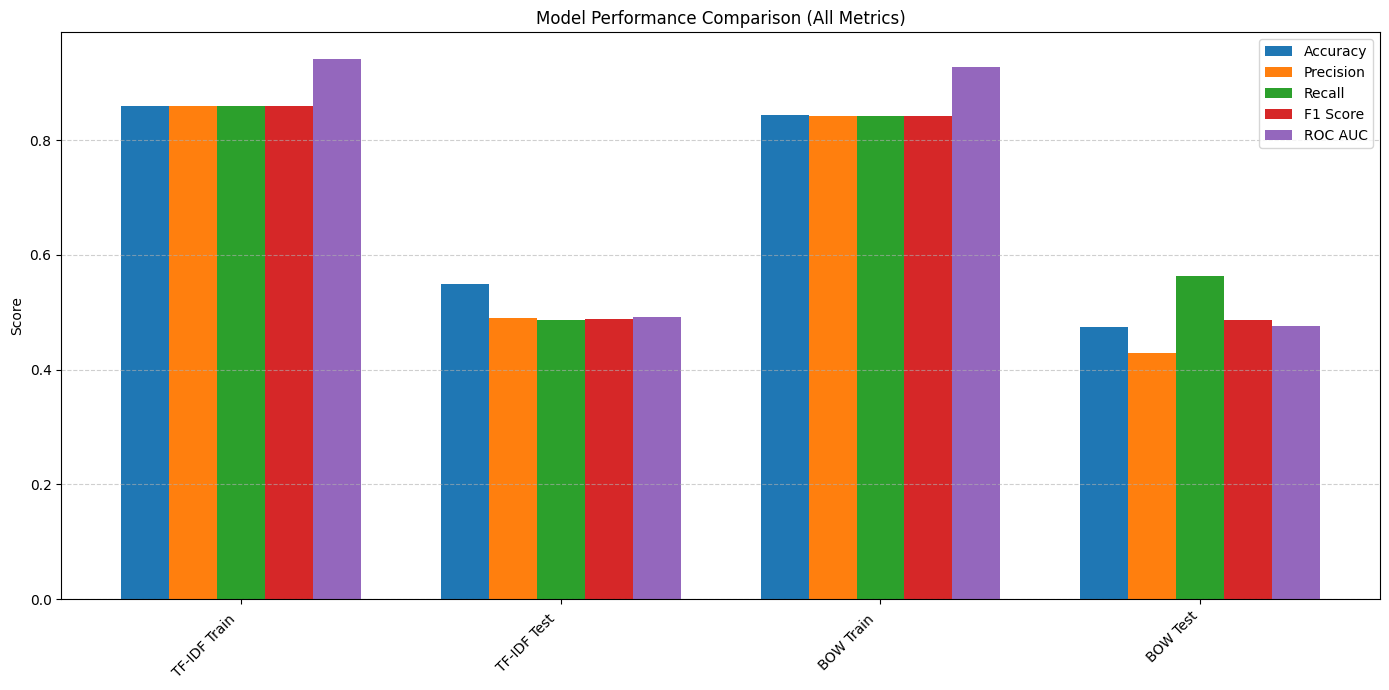

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Prepare the data
data = {
    "Model": [
        "TF-IDF Train", "TF-IDF Train (Threshold on CTR differences ≥ 0.1)",
        "TF-IDF Test", "TF-IDF Test (Threshold on CTR differences ≥ 0.1)",
        "BOW Train", "BOW Train (Threshold on CTR differences ≥ 0.1)",
        "BOW Test", "BOW Test (Threshold on CTR differences ≥ 0.1)"
    ],
    "Accuracy": [0.8454, 0.8587, 0.4981, 0.5500, 0.8454, 0.8443, 0.4981, 0.4737],
    "Precision": [0.8319, 0.8599, 0.4293, 0.4892, 0.8319, 0.8422, 0.4293, 0.4289],
    "Recall": [0.8479, 0.8599, 0.4631, 0.4871, 0.8479, 0.8421, 0.4631, 0.5636],
    "F1 Score": [0.8398, 0.8599, 0.4455, 0.4882, 0.8398, 0.8422, 0.4455, 0.4871],
    "ROC AUC": [0.9271, 0.9406, 0.4922, 0.5376, 0.9271, 0.9275, 0.4922, 0.4766]
}
data = {
    "Model": [
        "TF-IDF Train ",
         "TF-IDF Test ",
         "BOW Train ",
         "BOW Test"
    ],
    "Accuracy": [ 0.8587,  0.5500, 0.8443, 0.4737],
    "Precision": [ 0.8599,  0.4892,  0.8422, 0.4289],
    "Recall": [ 0.8599,  0.4871,  0.8421,  0.5636],
    "F1 Score": [ 0.8599,0.4882,  0.8422, 0.4871],
    "ROC AUC": [ 0.9406, 0.4922, 0.9275, 0.4766]
}
# Create DataFrame
df = pd.DataFrame(data)
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]

# Create a single grouped bar plot
bar_width = 0.15
x = np.arange(len(df["Model"]))

plt.figure(figsize=(14, 7))

for i, metric in enumerate(metrics):
    plt.bar(x + i * bar_width, df[metric], width=bar_width, label=metric)

plt.xticks(x + bar_width * 2, df["Model"], rotation=45, ha='right')
plt.ylabel("Score")
plt.title("Model Performance Comparison (All Metrics)")
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

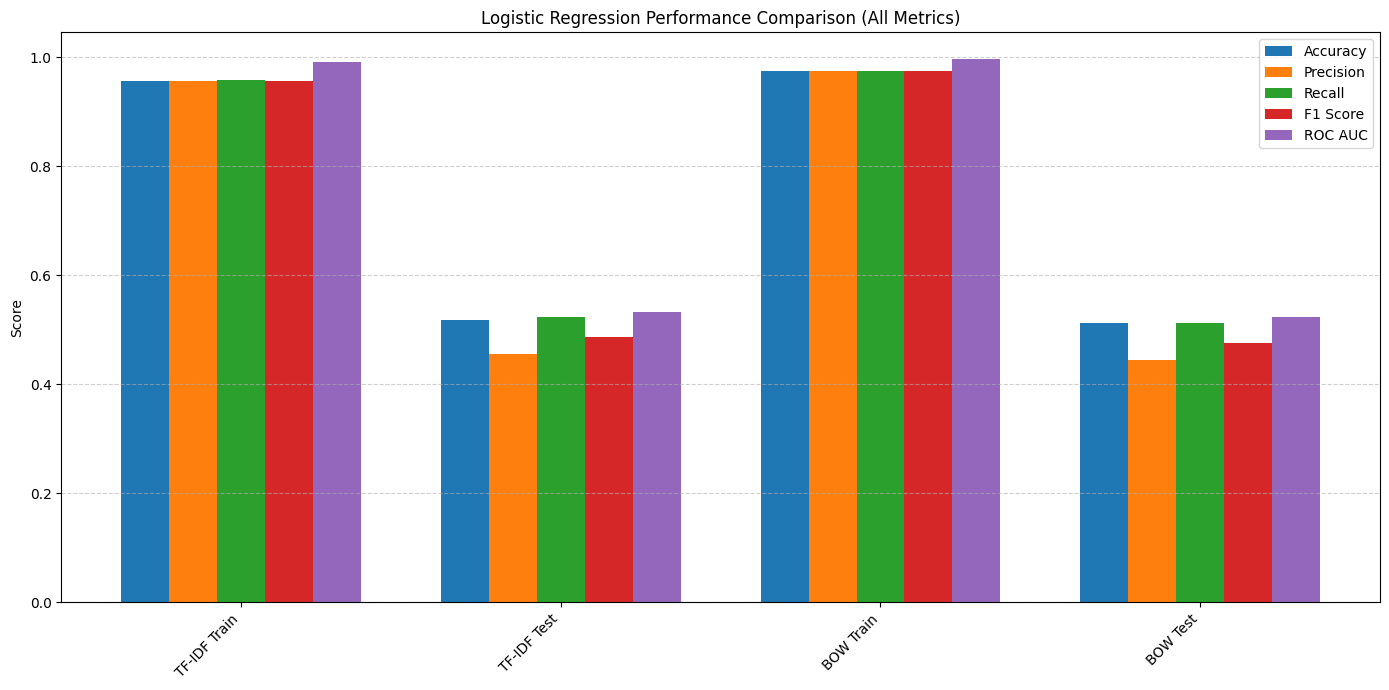

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the data
data = {
    "Model": [
        "TF-IDF Train", "TF-IDF Test",
        "BOW Train", "BOW Test"
    ],
    "Accuracy": [0.9573, 0.5175, 0.9756, 0.5125],
    "Precision": [0.9564, 0.4561, 0.9756, 0.4453],
    "Recall": [0.9584, 0.5230, 0.9757, 0.5122],
    "F1 Score": [0.9574, 0.4873, 0.9757, 0.4765],
    "ROC AUC": [0.9911, 0.5321, 0.9961, 0.5237]
}

# Create DataFrame
df_logreg = pd.DataFrame(data)

# Plot settings
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]
bar_width = 0.15
x = np.arange(len(df_logreg["Model"]))

# Create the grouped bar chart
plt.figure(figsize=(14, 7))
for i, metric in enumerate(metrics):
    plt.bar(x + i * bar_width, df_logreg[metric], width=bar_width, label=metric)

plt.xticks(x + bar_width * 2, df_logreg["Model"], rotation=45, ha='right')
plt.ylabel("Score")
plt.title("Logistic Regression Performance Comparison (All Metrics)")
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()
